In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

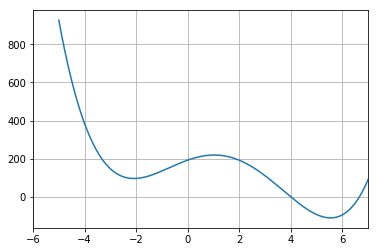

In [2]:
def objective_function(x):
    return (-4*(x**2-16)*(x+4) + ((x**3+x**2)*(x-4)) + ((x+4)**2)*(x-4))


x = np.linspace(-5, 8, num = 1000)
y = objective_function(x)
plt.plot(x, y)
plt.xlim(-6,7)
plt.grid(True)

In [3]:
x0 = [-3.0,4.0,2.0]
x1 = -3.0
x2 = 2

b = (-5.0, 8.0)
bnds = (b,b,b)

sol1 = minimize(objective_function, x1, method='nelder-mead', bounds=b)
sol2= minimize(objective_function, x2, method='nelder-mead', bounds=b)
sol = sol2
#目的関数の最適解
print("目的関数の最適解:{}".format(sol2.x))

目的関数の最適解:[5.55166016]


C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  RuntimeWarning)


In [4]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LN
import networkx as nx
import copy
from scipy.optimize import minimize
# ========================================================================================================================== #
#コード作成の順番
"""
1: Agent_subgrad(object)のclassを作る
2: 各パラメータの値を決定
3: agentの関数の決定．
4: 固定連結無向グラフを作成・プロット
5: 重み行列の決定
6: Initialization
7: Plot the initial estimation
8: アルゴリズムの構築
9: グラフのプロット
10: 収束しているかの確認

目的関数
    F(z) = F_1(z) + F_2(z) + F_3(z)
    F_1(z) = 2z^2
    F_2(z) = 3z~2 + 2z
    F_3(z) = 4z^2 + 2
"""
# ========================================================================================================================== #
#classの設定
class Agent_gradient(object):
    #def __init__() : エージェントの勾配に必要な，変数をAgent_gradient classが持つself変数に代入する
    def __init__(self, N, n, weight, name, stepsize, eventtrigger):
        self.N = N #agentの数
        self.n = n #agentの持つ変数の次元
        self.name = name
        self.weight = weight
        self.stepsize = stepsize
        self.eventtrigger = eventtrigger

        self.initial_state()

    #Initialization : agentの初期状態を決定する
    def initial_state(self):
        self.z_i = np.random.random_integers(-6, 6) #agentのcost functionの決定変数
        self.z = np.zeros([self.N, self.n])
        self.z_send = np.zeros([self.N, self.n])
        
    #Compute the gradient 非凸での勾配を考える．
    def grad(self, i, x):
        if i == 0:
            return -4*(3*x**2+8*x-16)
        elif i == 1:
            return 4*x**3-9*x**2-8*x
        elif i == 2:
            return 3*x**2+8*x-16
    
    #Compute the step-size
    def step_size(self, t, stepsize):
        return stepsize / (t+1)

    #Send the state to the neighbor agents　
    def send(self, j):
        self.z_send[j] = self.z_i
        return self.z_i, self.name
    
    #Receive the states from the neighbor agents
    def receive(self, z_j, name):
        self.z[name] = z_j
        
    #Compute the event_trigger_figure(閾値) eventtrigger / (t+1)
    def event_trigger(self, t, eventrigger):
        return eventrigger / (t + 1)
    
    #Update the state by the distributed subgradient algorithm
    def update(self, t):
        self.diff = self.z - self.z_send
        self.z_i = self.z_i + np.dot(self.weight, self.diff)  - self.step_size(t, self.stepsize) * self.grad(i = self.name, x = self.z_i)
        self.z_send[self.name] = self.z_i
        self.z[self.name] = self.z_i
# ========================================================================================================================== #
#objective function for problem in this simulation    
def objective_function(x):
    return (-4*(x**2-16)*(x+4) + ((x**3+x**2)*(x-4)) + ((x+4)**2)*(x-4))
# ========================================================================================================================== #
#Parameters
#Number of agents
N = 3

#Number of dimensions of the decision variable
n = 1

#Coefficient of decision of stepsize : a(t) = a / t
stepsize = 0.008
        
# Coefficient of the edge weight  w_if = wc / max_degree
wc = 0.8

#Number of iterations
iteration = 1000

# Interval for figure plot 
fig_interval = 200

# plot region
x_min = -6
x_max = 6

#Coefficient of decision of stepsize : E_ij(t) = E(t) = eventtrigger / (t+1)
eventtrigger = [0, 3, 10]

# Randomization seed
np.random.seed(10)
# ========================================================================================================================== #
# Communication Graph
A = np.array(
    [[1, 1, 1],
     [1, 1, 0],
     [1, 0, 1]])

G = nx.from_numpy_matrix(A)

# Weighted Stochastic Matrix P
a = np.zeros(N)

for i in range(N):
    a[i] = copy.copy(wc / nx.degree(G)[i])

P = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        if i != j and A[i][j] == 1:
            a_ij = min(a[i], a[j])
            P[i][j] = copy.copy(a_ij)
            P[j][i] = copy.copy(a_ij)

for i in range(N):
    sum = 0.0
    for j in range(N):
        sum += P[i][j]
    P[i][i] = 1.0 - sum
# ========================================================================================================================== #
#Agentsの初期状態を統一する
Agent_array = []
initial_state_array = []
for i in range(N):
    Agent_array.append(Agent_gradient(N, n, P[i], i, stepsize, eventtrigger))
    initial_state_array.append(Agent_array[i].z_i)

#初期状態を表示したい場合
print('At initial time:')
for i in range(len(initial_state_array)):
    print('state of agent{} : {}'.format(i, initial_state_array[i]))

#plot時の評価指標に用いる配列
tmp_diff_estim_array = [[], [], []] #Agentの見積もり状態をいれる配列
    
#Algorithm 
for e in range(len(eventtrigger)): #eventtigger と　stepsize の行列から要素を指定
    #initialization
    Agents = copy.deepcopy(Agent_array)
    
    count = 0
    
    z0 = [np.linspace(x_min, x_max) for i in range(N)]

    print('E =', Agents[0].eventtrigger[e])
    
    for i in range(N):
        for j in range(N):
            if i != j and A[i][j] == 1:
                #Send the state to the neighbor agents at initial time 
                state, name = Agents[i].send(j)

                #Receive the state from the neighbor agents at initial time
                Agents[j].receive(state, name)

    for t in range(iteration):    
        sum_diff_at_t = 0
        for agent in Agents:
            sum_diff_at_t += np.abs(objective_function(agent.z_i) - sol.fun)
        tmp_diff_estim_array[e].append(sum_diff_at_t)
        # ========================================================================================================================== #
        # Transfer data among agents
        for i in range(N):
            for j in range(N):
                if i != j and A[i][j] == 1:
                    if LN.norm(Agents[i].z_i - Agents[i].z_send[j], ord=1) > Agents[i].event_trigger(t+1, Agents[i].eventtrigger[e]):
                            count += 1
                            #Send the state to the neighbor agents
                            state, name = Agents[i].send(j)
                            #Receive the state from the neighbor agents
                            Agents[j].receive(state, name)

        # Update the state
        for i in range(N):
            Agents[i].update(t+1)
        
    print('Agents condition after iteration')
    for i in range(N):
        print('Agents', i, Agents[i].z_i)

    tmp_local_minima = sol
        
    print('objective function : {}'.format(tmp_local_minima.fun))

    print('objective function estimated by Agent | 1:{}, 2:{}, 3:{}'.format(objective_function(Agents[0].z_i), objective_function(Agents[1].z_i), objective_function(Agents[2].z_i)))
    
    diff = 0 
    
    for agent in Agents:
        diff += np.abs(tmp_local_minima.fun-objective_function(agent.z_i))
    
    print('count : {}'.format(count))
    print('difference : {}'.format(diff))

C:\Users\Adachi Takashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. Please call randint(-6, 6 + 1) instead


At initial time:
state of agent0 : 3
state of agent1 : -2
state of agent2 : -6
E = 0
Agents condition after iteration
Agents 0 [-1.95778238]
Agents 1 [-1.95567638]
Agents 2 [-1.95682049]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[96.41511306], 2:[96.43981538], 3:[96.42634919]
count : 3996
difference : [623.38958186]
E = 3
Agents condition after iteration
Agents 0 [-1.95349409]
Agents 1 [-1.95244223]
Agents 2 [-1.95541405]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[96.46580699], 2:[96.47847807], 3:[96.44291857]
count : 314
difference : [623.49550786]
E = 10
Agents condition after iteration
Agents 0 [-1.94128176]
Agents 1 [-1.94138317]
Agents 2 [-1.9322834]
objective function : -111.36943474380195
objective function estimated by Agent | 1:[96.61862813], 2:[96.61730779], 3:[96.73917023]
count : 308
difference : [624.08341039]


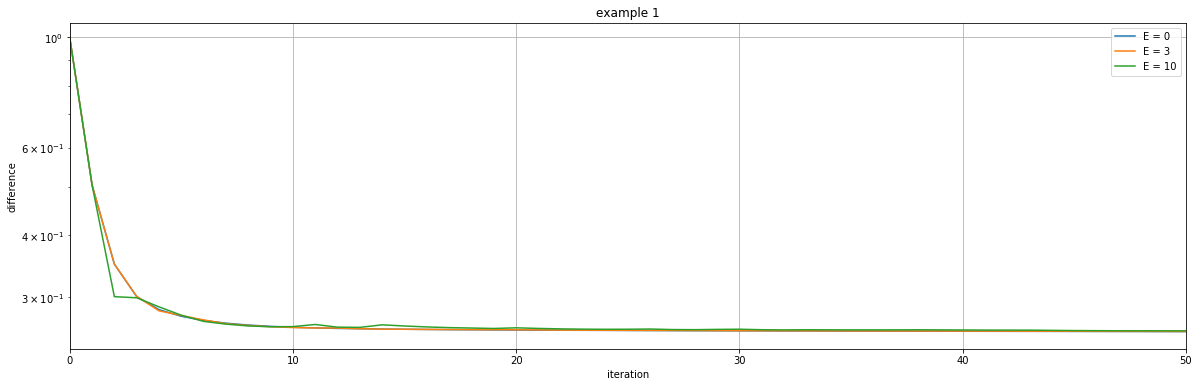

In [10]:
initial_object_state_diff = 0
for t in initial_state_array:
    initial_object_state_diff += np.abs(objective_function(t) - sol.fun)

# グラフの大きさを指定
plt.figure(figsize=(20, 6))
num_iteration = [i for i in range(iteration)]
# label= と　legendでラベルを付ける
for i in range(3):
    plt.plot(num_iteration, tmp_diff_estim_array[i]/initial_object_state_diff, label='E = {}'.format(eventtrigger[i]))
plt.legend()

plt.xlim(0,50)

plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('difference')
plt.grid(True)
plt.title('example 1')

plt.show()